&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&ensp;
[Home Page](../Start_Here.ipynb)


[Previous Notebook](Manipulation_of_Image_Data_and_Category_Determination_using_Text_Data.ipynb)
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
[1](The_Problem_Statement.ipynb)
[2](Approach_to_the_Problem_&_Inspecting_and_Cleaning_the_Required_Data.ipynb)
[3](Manipulation_of_Image_Data_and_Category_Determination_using_Text_Data.ipynb)
[4]
[5](Competition.ipynb)
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
[Next Notebook](Competition.ipynb)

# Tropical Cyclone Intensity Estimation using a Deep  Convolutional Neural Network - Part 3 

**Contents of the this notebook:**

- [Understand the drawbacks of existing solution](#Understanding-the-drawbacks)
- [Working out the solution](#Working-out-the-solution)
    - [Data Augmentation](#Data-Augmentation)
- [Training the model](#Training-the-Model-with-Data-Augmentation)

**By the end of this notebook participant will:**

- Learn about improving the previous model.
- Data Augmentation.
- Tweaking Hyperparameters.

# Understanding the drawbacks

```python3
Simply put, a machine learning model is only as good as the data it is fed with
```
We have achieved an accuracy nearly of ~85% running with 4 epochs. Now we will try to increase the accuracy by taking a closer look at the dataset and images. We can observe the following from our previous notebook : 

First thing that we will notice from the category count is that the number of images per category is very un-uniform with ratios of TC: H5 **greater than 1:20**, This imbalance can bias the vision of our CNN model because predicting wrong on the minority class wouldn't impact the model a lot as the class contribution is less than 5% of the dataset.

The same can be shown also by the heatmap we obtained in the previous notebook : Notice Most of Classes with higher data was predicted correctly and the minority class was more mis-predicted than the other classes 
![alt_text](images/heatmap.png)


Let us see now how we solve that problem using data augmentation : 

## Working out the solution

## Data Augmentation 

To decrease the un-uniformity, we will be flipping and rotating images to compensate for the lack of data for class with less samples: 

![alt text](images/augment.png)


We will be using OpenCV for Flipping and Image Rotations. 

``` python
cv2.flip(img,0)
cv2.flip(img,1)
cv2.warpAffine(img, cv2.getRotationMatrix2D(center, 90, 1.0), (h, w))
cv2.warpAffine(img, cv2.getRotationMatrix2D(center, 180, 1.0), (w, h))
cv2.warpAffine(img, cv2.getRotationMatrix2D(center, 270, 1.0), (h, w))
```

There are other ways to counter data imbalance such as Class weightage, Oversampling, SMOTE etc..

# Training the Model with Data Augmentation 


We create a new function called `augmentation(name,category,filenames,labels,i)` and here we add more samples to Category which have imbalanced data.  

In [1]:
import sys
sys.path.append('/workspace/python/source_code')
# Import Utlility functions
from utils import * 
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"


# Define the Augmentation Function 
def augmentation(name,category,filenames,labels,i):
    # Important Constants
    file_path = "Dataset/Aug/"
    images = []
    (h, w) = (232,232)
    center = (w / 2, h / 2)
    angle90 = 90
    angle180 = 180
    angle270 = 270
    scale = 1.0
    img = load_image(name , interpolation = cv2.INTER_LINEAR)
    
    
    if category == 0 :
        images.append(cv2.flip(img,0))
    elif category == 1 :
        pass
    elif category == 2 :
        pass
    elif category == 3 :
        pass
    elif category == 4 :
        pass
    elif category == 5 :
        pass
    elif category == 6 :
        pass
    elif category == 7 :
        images.append(cv2.flip(img,0))
        
        
    for j in range(len(images)):
        cv2.imwrite(file_path+str(i+j)+'.jpeg',images[j])
        filenames.append(file_path+str(i+j)+'.jpeg')
        labels.append(category)
    i = i + len(images)
    return i

##### We pass this function to our `load_dataset()` function to generate these augmentations. 

Kindly wait for a couple of minutes while augments the images.

In [2]:
filenames,labels = load_dataset(augment_fn = augmentation)

................................
28574


In [3]:
# Set the Size of the Validation set
val_filenames , val_labels = make_test_set(filenames,labels,val=0.1)

[357, 357, 357, 357, 357, 357, 357, 357]
Counter({2: 7923, 3: 5326, 1: 3790, 4: 2921, 5: 2323, 6: 2165, 7: 739, 0: 531})


In [4]:
#Make train test set 
test = 0.1
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(filenames, labels, test_size=test, random_state=1)

In [5]:
import tensorflow as tf
y_train = tf.one_hot(y_train,depth=8)
y_test = tf.one_hot(y_test,depth=8)
val_labels = tf.one_hot(val_labels,depth=8)

In [6]:
# Make Dataset compatible with Tensorflow Data Pipelining.
train,test,val = make_dataset((x_train,y_train,128),(x_test,y_test,32),(val_filenames,val_labels,32))

# The model described in the paper :

Now we will be using the model described in the paper to evaluate it's accuracy on the new dataset.

![alt_text](images/model.png)

In [7]:
import numpy as np
tf.random.set_seed(1337)

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten ,Dropout, MaxPooling2D
from tensorflow.keras import backend as K 

#Reset Graphs and Create Sequential model

K.clear_session()
model = Sequential()
#Convolution Layers

model.add(Conv2D(64, kernel_size=10,strides=3, activation='relu', input_shape=(232,232,3)))
model.add(MaxPooling2D(pool_size=(3, 3),strides=2))
model.add(Conv2D(256, kernel_size=5,strides=1,activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=2))
model.add(Conv2D(288, kernel_size=3,strides=1,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=1))
model.add(Conv2D(272, kernel_size=3,strides=1,padding='same',activation='relu'))
model.add(Conv2D(256, kernel_size=3,strides=1,activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=2))
model.add(Dropout(0.5))
model.add(Flatten())

#Linear Layers 

model.add(Dense(3584,activation='relu'))
model.add(Dense(2048,activation='relu'))
model.add(Dense(8, activation='softmax'))

# Print Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 75, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 256)       409856    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 288)       663840    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 288)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 272)       7

In [8]:
import functools
# Include Top-2 Accuracy Metrics 
top2_acc = functools.partial(tensorflow.keras.metrics.top_k_categorical_accuracy, k=2)
top2_acc.__name__ = 'top2_acc'

#Define Number of Epochs
epochs = 4

#But Training our model from scratch will take a long time
#So we will load a partially trained model to speedup the process 
model.load_weights("trained_16.h5")

# Optimizer
sgd = tensorflow.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9)


#Compile Model with Loss Function , Optimizer and Metrics
model.compile(loss=tensorflow.keras.losses.categorical_crossentropy, 
              optimizer=sgd,
              metrics=['accuracy',top2_acc])

# Train the Model 
trained_model = model.fit(train,
          epochs=epochs,
          verbose=1,
          validation_data=val)

# Test Model Aganist Validation Set
score = model.evaluate(test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Epoch 1/4
181/181 [==============================] - 57s 245ms/step - loss: 0.7175 - accuracy: 0.7548 - top2_acc: 0.9026 - val_loss: 0.4770 - val_accuracy: 0.8337 - val_top2_acc: 0.9443
Epoch 2/4
181/181 [==============================] - 13s 73ms/step - loss: 0.5526 - accuracy: 0.8028 - top2_acc: 0.9329 - val_loss: 0.4178 - val_accuracy: 0.8536 - val_top2_acc: 0.9468
Epoch 3/4
181/181 [==============================] - 15s 83ms/step - loss: 0.4849 - accuracy: 0.8278 - top2_acc: 0.9440 - val_loss: 0.3553 - val_accuracy: 0.8729 - val_top2_acc: 0.9576
Epoch 4/4
181/181 [==============================] - 13s 73ms/step - loss: 0.4486 - accuracy: 0.8376 - top2_acc: 0.9516 - val_loss: 0.3235 - val_accuracy: 0.8894 - val_top2_acc: 0.9667
Test loss: 0.2548527121543884
Test accuracy: 0.9195178747177124


### Visualisations

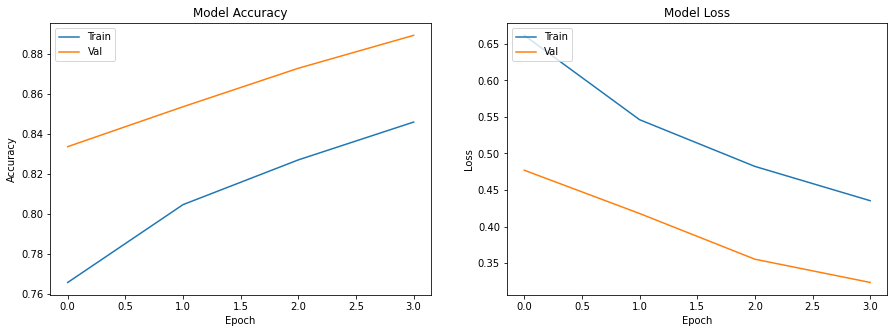

In [9]:
import matplotlib.pyplot as plt
f = plt.figure(figsize=(15,5))
ax = f.add_subplot(121)
ax.plot(trained_model.history['accuracy'])
ax.plot(trained_model.history['val_accuracy'])
ax.set_title('Model Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Val'])

ax2 = f.add_subplot(122)
ax2.plot(trained_model.history['loss'])
ax2.plot(trained_model.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Val'],loc= 'upper left')

plt.show()

<AxesSubplot:>

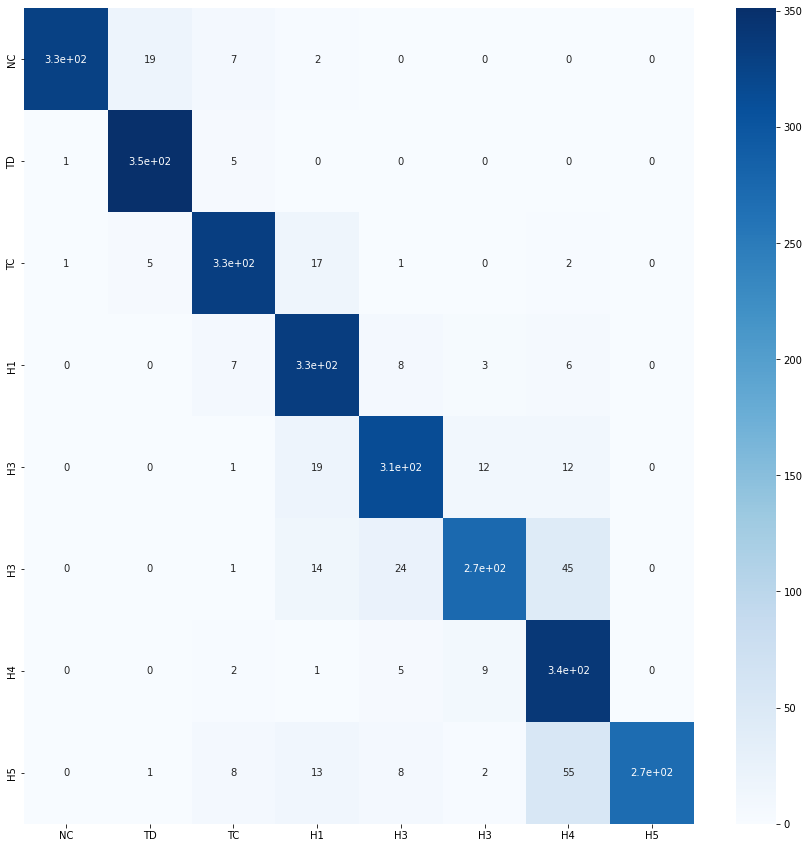

In [10]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
import pandas as pd

#Plotting a heatmap using the confusion matrix

pred = model.predict(val)
p = np.argmax(pred, axis=1)
y_valid = np.argmax(val_labels, axis=1, out=None)
results = confusion_matrix(y_valid, p) 
classes=['NC','TD','TC','H1','H3','H3','H4','H5']
df_cm = pd.DataFrame(results, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (15,15))

sn.heatmap(df_cm, annot=True, cmap="Blues")

Let us now save our Model and the trained weights for future usage :

In [11]:
#Save Our Model 
model.save('cyc_pred.h5')

## Licensing
This material is released by OpenACC-Standard.org, in collaboration with NVIDIA Corporation, under the Creative Commons Attribution 4.0 International (CC BY 4.0).

&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&ensp;
[Home Page](../Start_Here.ipynb)


[Previous Notebook](Manipulation_of_Image_Data_and_Category_Determination_using_Text_Data.ipynb)
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
[1](The_Problem_Statement.ipynb)
[2](Approach_to_the_Problem_&_Inspecting_and_Cleaning_the_Required_Data.ipynb)
[3](Manipulation_of_Image_Data_and_Category_Determination_using_Text_Data.ipynb)
[4]
[5](Competition.ipynb)
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
[Next Notebook](Competition.ipynb)